In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#import pickle
import glob
#import matplotlib.image as mpimg
#from moviepy.editor import VideoFileClip
#from collections import deque
#import sys

## Camera Calibration

In [2]:
def camera_calibration():
    
    global camera_mtx,dist_coeff
    # Preparing the points for the object 
    objectPoints = np.zeros((6 * 9, 3), np.float32)
    objectPoints[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Storing all the points for the object and the image from all the images
    object_points = []
    image_points = []

    # Getting the directory of all of the calibrated images
    img = glob.glob('./camera_calibrations/*.jpg')
    images = None

    for indx, fname in enumerate(img):
        images = cv2.imread(fname)
        gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
        # it should be colored image or a 8-bit grayscale  
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            object_points.append(objectPoints)
            image_points.append(corners)

    # getting the size of the Image 
    imageSize = (images.shape[1], images.shape[0])

    # Calibrate camera
    ret, camera_mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imageSize, None, None)

camera_calibration()

## Undistorting image using camera matrix and distortion coefficient

In [3]:
def undistort(images, camera_mtx, dist_coeff):
    """
    we will use cv2.undistort to undistort
    :param images: we will assume that the input image is RGB (imread by mpimg)
    :param camera_mtx: it the parameter for the calibration of the camera 
    :param dist_coeff:is a calibration parameter for the camera
    :return: Undistorted image
    """
   
    undistorted_img = cv2.undistort(images, camera_mtx, dist_coeff, None, camera_mtx)

    return undistorted_img

## Testing a Road Image

Text(0.5, 1.0, 'Undistored Image')

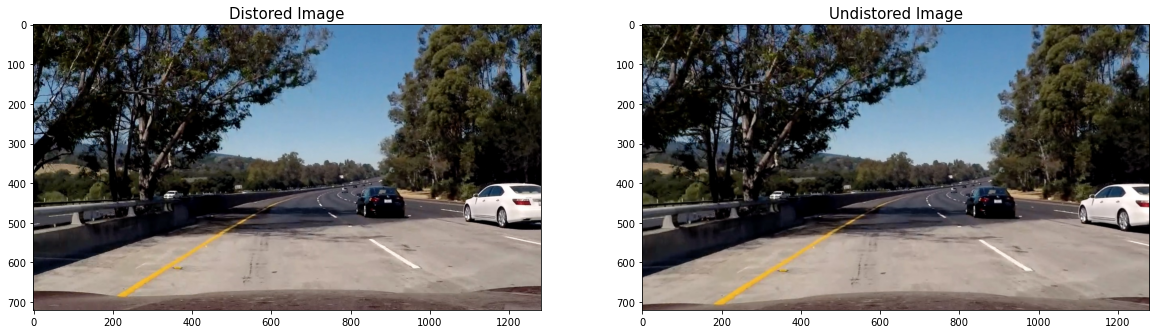

In [4]:
img = cv2.imread('test_images/test5.jpg')

# transform to BGR to fit cv2.imread
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort(img, camera_mtx, dist_coeff)


f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Distored Image', fontsize = 15)

ax2.imshow(undistorted_img)
ax2.set_title('Undistored Image', fontsize = 15)

## Perspective Transform and Inverse Perspective Transform

In [5]:
src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
def perspective_transform(img):
    """
    Perspective Transformation
    :param img:
    :return: warped image
    """
    

    
    
    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def inv_perspective_transform(img):
    """
    Inverse Perspective Transformation
    :param img:
    :return: warped image
    """

    dst = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    src = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the inverse-perspective transform matrix 
    #(which is just perspective transform with src and dst interchanged)
    Minv = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, Minv, img_size)
    
    return warped

Text(0.5, 1.0, 'Warped Image')

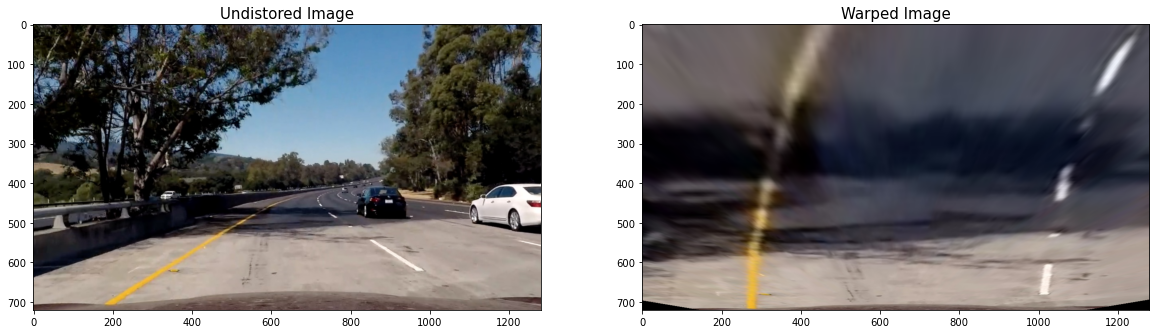

In [6]:
warped = perspective_transform(undistorted_img)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undistorted_img)
ax1.set_title('Undistored Image', fontsize = 15)

ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize = 15)

## Thresholding

In [7]:
#differences in RGB space do not correspond well to perceived differences in color. 
#That is, two colors can be close in RGB space but appear very different to humans and vice versa.

#LUV decouple the "color" (chromaticity, the UV part) and "lightness" (luminance, the L part) of color.
#Thus in object detection, it is common to match objects just based on the UV part,
#which gives invariance to changes in lighting condition.

#LAB is designed to approximate human vision. The L* component closely matches human perception of lightness
#is useful for predicting small differences in color.

#So we will use B channel from LAB space identified yellow lanes while L channel from LUV space could detect white lanes

def thresholding(img, l_thresh=(195, 255), b_thresh=(140, 200)):
    l_LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:, :, 0]
    l_bin = np.zeros_like(l_LUV)
    l_bin[(l_LUV >= l_thresh[0]) & (l_LUV <= l_thresh[1])] = 1

    b_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:, :, 2]
    b_bin = np.zeros_like(b_LAB)
    b_bin[(b_LAB >= b_thresh[0]) & (b_LAB <= b_thresh[1])] = 1

    thresholded_img = np.zeros_like(l_LUV)
    thresholded_img[(l_bin == 1) | (b_bin == 1)] = 1

    return thresholded_img

Text(0.5, 1.0, 'Threshold Image')

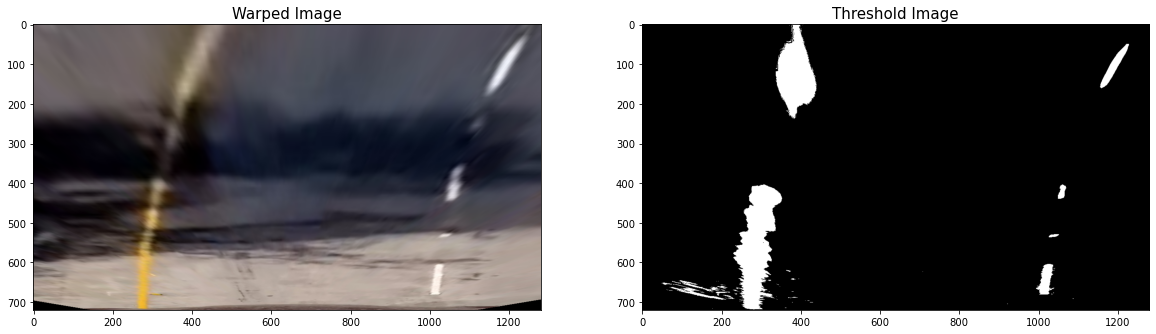

In [8]:
filtered=thresholding(warped)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize = 15)

ax2.imshow(filtered, cmap='gray')
ax2.set_title('Threshold Image', fontsize = 15)

## Histogram For Thresholded Wraped image

In [9]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

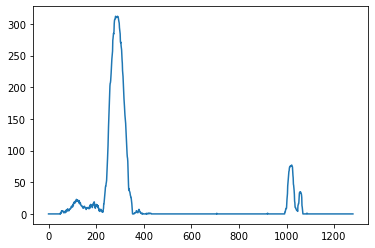

In [10]:
plt.plot(get_hist(filtered))